In [6]:
%matplotlib notebook

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.sparse.linalg
from scipy.interpolate import interp1d

In [90]:
import pickle
with open('grace_gps_range_error.pickle','rb') as f:
    gps_error_data = pickle.load(f)

In [91]:
gps_error_data

{'range_diff_meters': array([-0.00064933, -0.00064006, -0.00063084, ..., -0.0049529 ,
        -0.00499438, -0.00503589]),
 'time_seconds': array([    0,     2,     4, ..., 86394, 86396, 86398])}

In [119]:
#as the angle (measured from Earth center along orbit) between LGS and interferometer decreases, take exposure every "dnt" radians
dnt = 0.03
#star observing when the satellites are 25 degrees apart, and finish when 25/4 degrees apart
nt_start = np.pi/2 - np.radians(25/2)
nt_finish = np.pi/2 - np.radians(25/8)
#note on axes: axis 0 is for different mirrors; axis 1 is for different times
nt0 = np.arange(nt_start,nt_finish,dnt).reshape((1,-1))

orbital_period = 90*60#seconds (roughly)

B = 10/np.cos(nt_start)#max. baseline as appears in the SPIE paper; since here the observation begins later, this needs to be increased accordingly

nm = 2 #number of mirrors
sigma_pos = 0.01 #for now assume noraml i.i.d. error; this is the standard deviation in meters

#placeholders for nominal baselines, perturbed baselines, and optical path delays after compensations
baselines = []
baselines_nom = []
delays = []

passes = 2**6#total number of orbits to collect observations


In [120]:
# noise_scaling = 0.01/np.std(gps_error_data['range_diff_meters'])
noise_scaling = 2
gps_error_interp1d = interp1d(gps_error_data['time_seconds'],noise_scaling*gps_error_data['range_diff_meters'])
gps_error_interp1d = interp1d(gps_error_data['time_seconds'],0.01*gps_error_data['range_diff_meters'])
gps_error_interp = lambda t,t0: gps_error_interp1d((t-t0)%gps_error_data['time_seconds'][-1])

get_rand_t0 = lambda: gps_error_data['time_seconds'][np.random.randint(len(gps_error_data['time_seconds']))]

rand_t0s_c = [get_rand_t0() for i in range(3)]
rand_t0s_m = [get_rand_t0() for i in range(3*nm)]
rand_t0s_l = [get_rand_t0() for i in range(3)]

c_xpos_error_fn = lambda t: gps_error_interp(t,rand_t0s_c[0])
c_ypos_error_fn = lambda t: gps_error_interp(t,rand_t0s_c[1])
c_zpos_error_fn = lambda t: gps_error_interp(t,rand_t0s_c[2])

m_xpos_error_fn = [lambda t: gps_error_interp(t,rand_t0s_m[3*m]) for m in range(nm)]
m_ypos_error_fn = [lambda t: gps_error_interp(t,rand_t0s_m[3*m+1]) for m in range(nm)]
m_zpos_error_fn = [lambda t: gps_error_interp(t,rand_t0s_m[3*m+2]) for m in range(nm)]

l_xpos_error_fn = lambda t: gps_error_interp(t,rand_t0s_l[0])
l_ypos_error_fn = lambda t: gps_error_interp(t,rand_t0s_l[1])
l_zpos_error_fn = lambda t: gps_error_interp(t,rand_t0s_l[2])

<IPython.core.display.Javascript object>


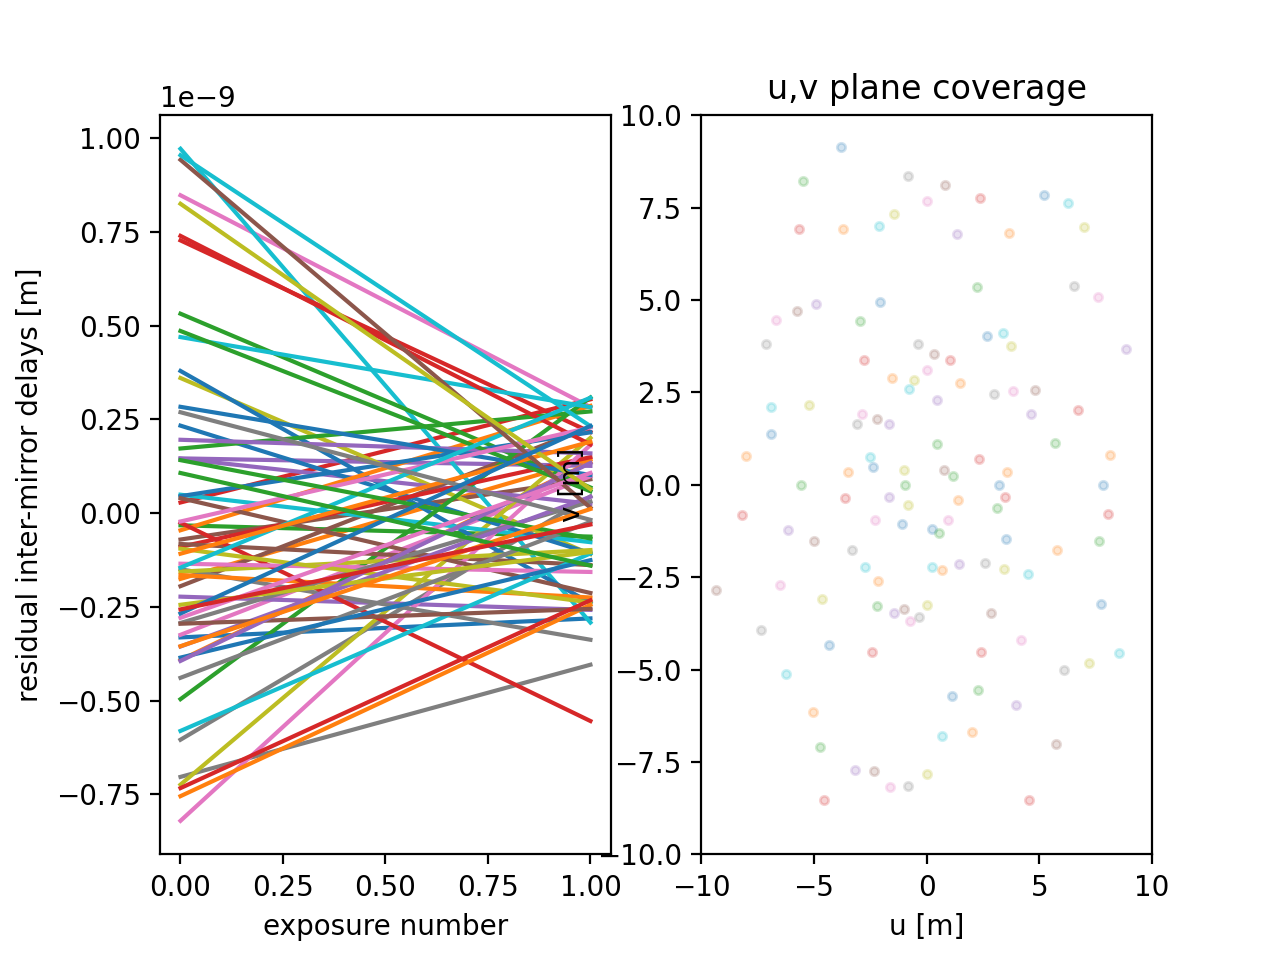

(-10.0, 10.0)

In [121]:


plt.figure()

passnum = 0
for theta0 in np.arange(passes)*(2*np.pi/passes):#theta0 is a rotation angle in the UV plane; achieved by manuevering between passes
    nt = nt0 + np.random.random()*dnt #add a random shift to exposure time; really helps with singular values

    # Time from start of observation [seconds]
    rel_times = orbital_period*(passnum + (nt[0]-nt[0][0])/(2*np.pi))
    
    #nominal position of the combiner; frame of CW equations; see SPIE paper
    xc_nom = B/np.sqrt(12)*np.cos(nt)
    yc_nom = -2*B/np.sqrt(12)*np.sin(nt)
    zc_nom = nt*0
   
    #perturbed position of combiner; TODO:
    #1. this should be split further into a) position perturbed by best "online" GPS accuracy and b) position known after "offline" GPS post processing
    #2. random disturbances are i.i.d. here; need  to be based on a realistic PSD
    #3. the errors need to be added in an inertial frame, not the CW frame
#     xc = xc_nom + np.random.normal(0,sigma_pos,xc_nom.shape)
#     yc = yc_nom + np.random.normal(0,sigma_pos,xc_nom.shape)
#     zc = zc_nom + np.random.normal(0,sigma_pos,xc_nom.shape)
    xc = xc_nom + c_xpos_error_fn(rel_times)
    yc = yc_nom + c_ypos_error_fn(rel_times)
    zc = zc_nom + c_zpos_error_fn(rel_times)
        
    #mirrors' nominal position
    xm_nom = np.array([0*nt[0] for m in range(nm)])
    ym_nom = np.array([B/2*np.cos(m*2*np.pi/nm+theta0) + 0*nt[0] for m in range(nm)])
    zm_nom = np.array([B/2*np.sin(m*2*np.pi/nm+theta0)*np.cos(nt[0]) for m in range(nm)])

    #mirrors' perturbed position; TODO:
    #1. errors should be split (see above)
    #2. erros should be similar between mirrors (DGPS)
#     xm = xm_nom + np.random.normal(0,sigma_pos,xm_nom.shape)
#     ym = ym_nom + np.random.normal(0,sigma_pos,xm_nom.shape)
#     zm = zm_nom + np.random.normal(0,sigma_pos,xm_nom.shape)
    xm = xm_nom + np.array([m_xpos_error_fn[m](rel_times) for m in range(nm)])
    ym = ym_nom + np.array([m_ypos_error_fn[m](rel_times) for m in range(nm)])
    zm = zm_nom + np.array([m_zpos_error_fn[m](rel_times) for m in range(nm)])
   
    #nominal coordinates in the UV plane
    u_nom = xm_nom*np.sin(nt) + ym_nom*np.cos(nt)
    v_nom = zm_nom
   
    #perturbed coordinates in the UV plane
    u = xm*np.sin(nt) + ym*np.cos(nt)
    v = zm
   
    rl = 2*6800000*np.cos(nt) #distance to LGS (roughly 6,800 km orbit)
    #nominal LGS position in (CW frame)
    xl_nom = -np.cos(nt)*rl
    yl_nom = np.sin(nt)*rl
    zl_nom = nt
   
    #perturbed LGS position
#     xl = xl_nom + np.random.normal(0,sigma_pos,xl_nom.shape)
#     yl = yl_nom + np.random.normal(0,sigma_pos,xl_nom.shape)
#     zl = zl_nom + np.random.normal(0,sigma_pos,xl_nom.shape)
    xl = xl_nom + l_xpos_error_fn(rel_times)
    yl = yl_nom + l_ypos_error_fn(rel_times)
    zl = zl_nom + l_zpos_error_fn(rel_times)
   
    dmc_nom = np.sqrt((xm_nom - xc_nom)**2 + (ym_nom - yc_nom)**2 + (zm_nom - zc_nom)**2) #nominal distances between mirrors and combiner
    dsm_nom = np.cos(nt)*xm_nom - np.sin(nt)*ym_nom #nominal optical path differences (relative to combiner) between star and mirrors
    dlm_nom = np.sqrt((xm_nom - xl_nom)**2 + (ym_nom - yl_nom)**2 + (zm_nom - zl_nom)**2) #nominal optical path distances between LGS and mirrors
   
    #perturbed OPLs and OPDs
    dmc = np.sqrt((xm - xc)**2 + (ym - yc)**2 + (zm - zc)**2)
    dsm = np.cos(nt)*xm - np.sin(nt)*ym
    dlm = np.sqrt((xm - xl)**2 + (ym - yl)**2 + (zm - zl)**2)
    
    baselines.append([])
    baselines_nom.append([])
    delays.append([])
   
    #this code is for computing optical path differences between each pair of mirrors
    for mi in range(nm): #mirror i
        for mj in range(mi+1,nm): #mirror j
            dismc = dsm[mi] + dmc[mi] #optical path from star through mirror i to combiner
            djsmc = dsm[mj] + dmc[mj] #same, mirror j
            dilmc = dlm[mi] + dmc[mi] #optical path from LGS through mirror i to combiner
            djlmc = dlm[mj] + dmc[mj] #same, mirror j
            dismc_nom = dsm_nom[mi] + dmc_nom[mi] #same, nominal
            dilmc_nom = dlm_nom[mi] + dmc_nom[mi] #same, nominal
            djsmc_nom = dsm_nom[mj] + dmc_nom[mj] #same, nominal
            djlmc_nom = dlm_nom[mj] + dmc_nom[mj] #same, nominal
           
            dijsmc = dismc - djsmc #optical path differences for starlight between mirror i and j
            dijlmc = dilmc - djlmc #optical path differences for LGS light between mirror i and j
            dijsmc_nom = dismc_nom - djsmc_nom #same, nominal
            dijlmc_nom = dilmc_nom - djlmc_nom #same, nominal
         
            #after closing the loop on LGS light, the unknown [residual delay] = [the difference between OPL of the star and the laser] - [nominal difference between OPL of the star and the laser]
            delays[-1].append(dijsmc - dijlmc + dijlmc_nom)
         
            #baseline is just the distance between the mirrors in the UV plane  
            baselines[-1].append([u[mi] - u[mj], v[mi] - v[mj]])
            baselines_nom[-1].append([u_nom[mi] - u_nom[mj], v_nom[mi] - v_nom[mj]])
           
            #plot residual delays
            plt.subplot(121)
            plt.plot(dijsmc - dijlmc + dijlmc_nom)
           
            #plot baselines
            plt.subplot(122)
            plt.scatter(u[mi] - u[mj], v[mi] - v[mj], marker=".", alpha=0.2)
            
    passnum += 1
           
plt.subplot(121)
plt.ylabel("residual inter-mirror delays [m]")
plt.xlabel("exposure number")
plt.subplot(122)
plt.title("u,v plane coverage")
plt.xlabel("u [m]")
plt.ylabel("v [m]")
plt.xlim((-10,10))
plt.ylim((-10,10))


<IPython.core.display.Javascript object>


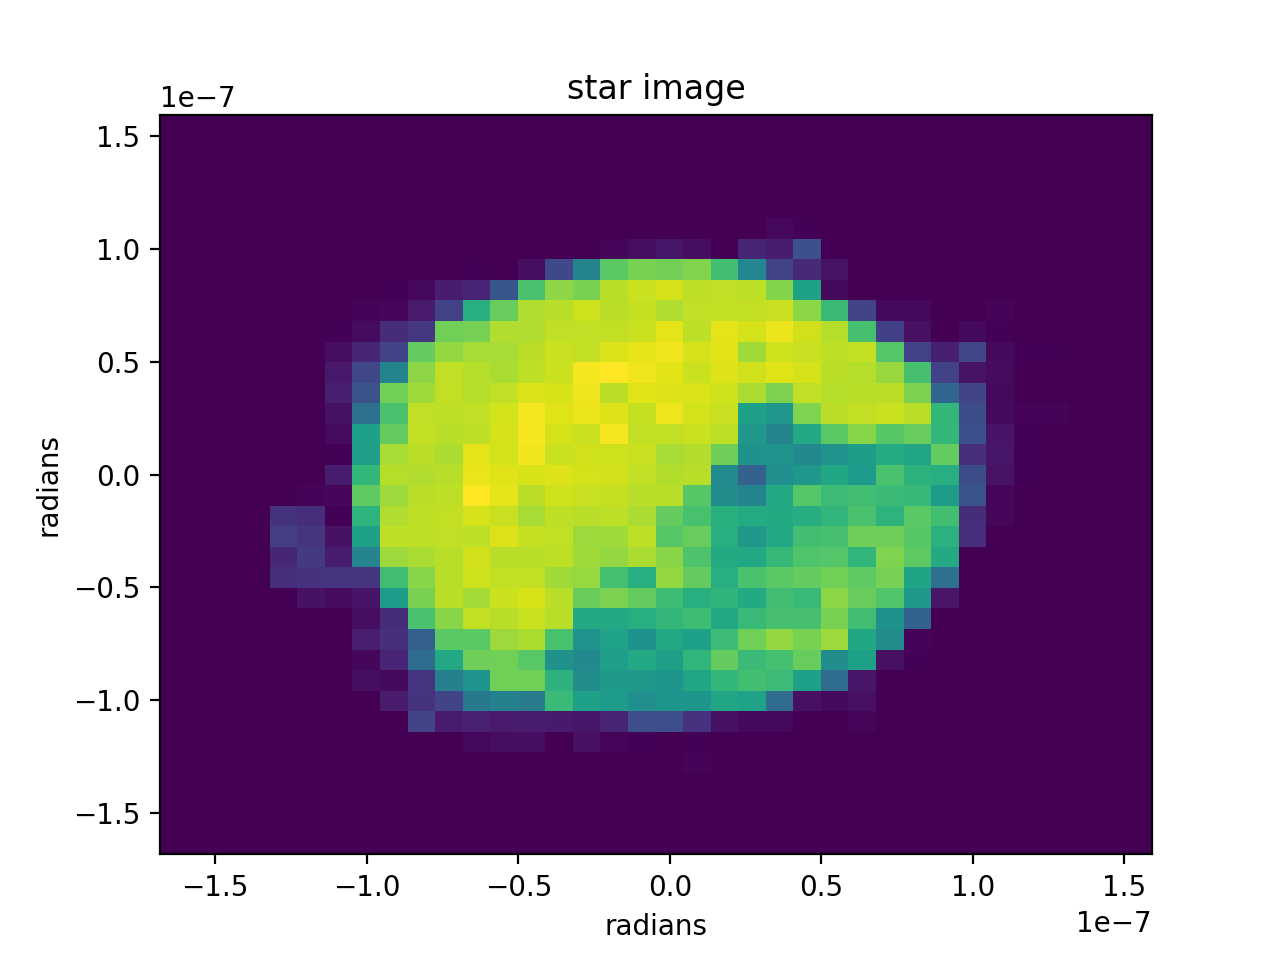

Text(0.5, 0, 'radians')

In [122]:
plt.figure()

#concatenate everything between different orbit passes
baselines = np.concatenate(baselines, axis=2)
baselines_nom = np.concatenate(baselines_nom, axis=2)
delays = np.concatenate(delays, axis=1)

#read "star" image
im = mpimg.imread("temp3.png")[20:-20,20:-20,0]
pix_D = 178 #star diameter in pixels of the fake image

#makes runs faster by reducing image resolution; TODO: make sure the results are not sensitive to this
im = im[::8,::8];pix_D = pix_D//8

#pixel coordinate of the image
X,Y = np.meshgrid(np.arange(im.shape[1])-0.5*im.shape[1], np.arange(im.shape[0])-0.5*im.shape[0])

angle_D = 2e-7 #star diameter in radians
a_full = im.ravel()/np.sum(im) #normilized vector of intensities that represents the star (the science product we're after)
#angle coordinates corresponding to each image pixel
star_angles_full = np.stack([X.ravel(), Y.ravel()], axis=1)*(angle_D/pix_D)

plt.pcolor(X*(angle_D/pix_D),Y*(angle_D/pix_D),np.flipud(im))
plt.title("star image")
plt.ylabel("radians")
plt.xlabel("radians")


<IPython.core.display.Javascript object>


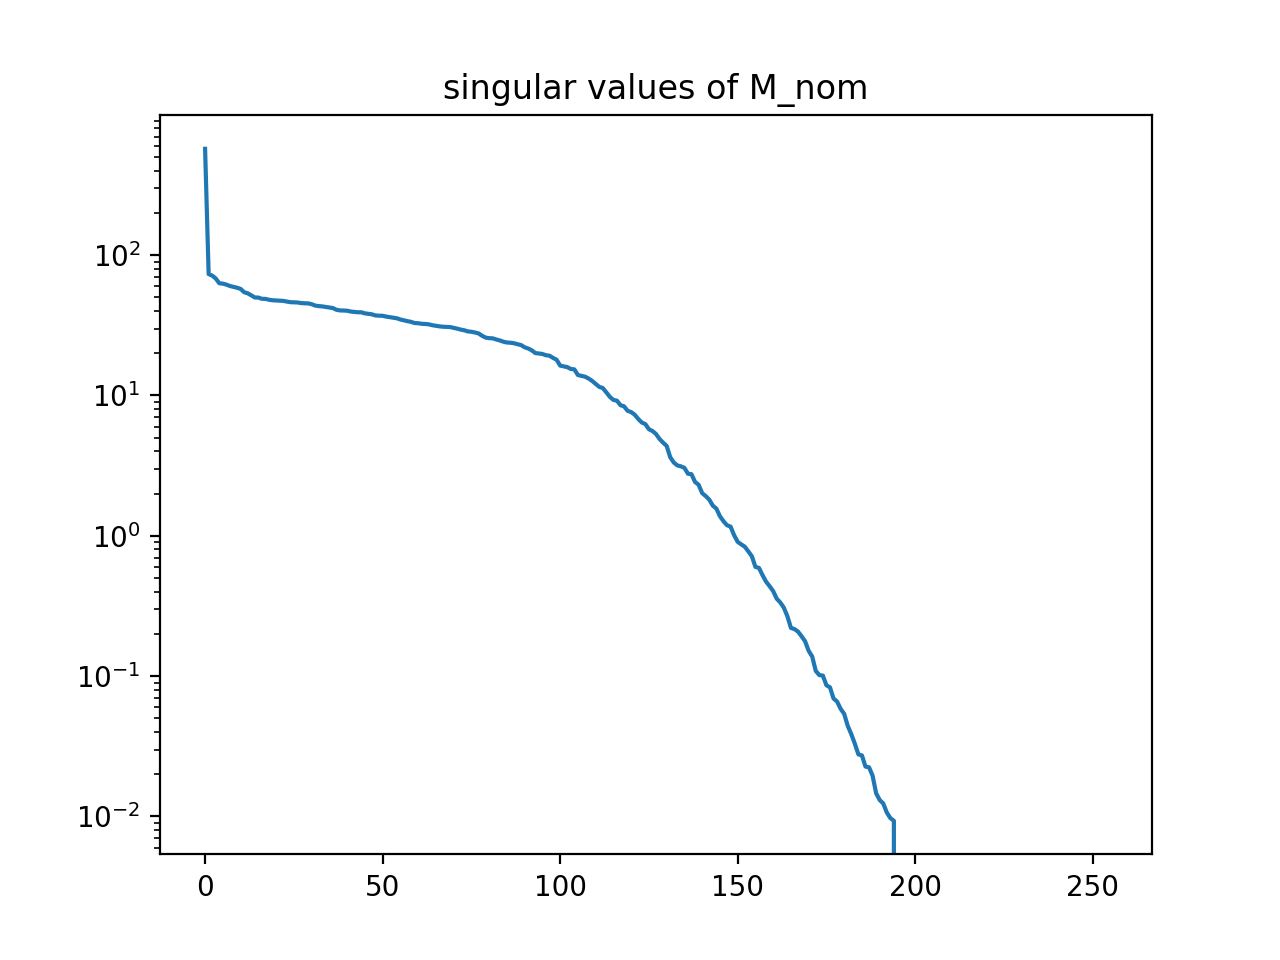

(1296, 255) (255,) (255, 256)


Text(0.5, 1.0, 'singular values of M_nom')

In [123]:
plt.figure()


lam = 550e-9#wavelength in meters

#Building M_nom, the matrix that transfers from the unknown a_full vector of star intensities to measured intensities under nominal conditions
# TODO: print shape of the arrays...
M_nom = []
for i in range(len(baselines)):
    #nominal phase differences of each elements of the star through each pair of mirrors
    phis_nom = star_angles_full.dot(baselines_nom[i])*(2*np.pi/lam)

    #we take two measurements with either 0 or pi/2 delay added between mirrors
    for zeta in np.pi/2*np.arange(2):
        #transfer vector between star elements (according to their phase delay) to the total measured intensity
        #i.e. (1 - np.cos(phis_nom + zeta)).dot(a_full) gives the measured intensity normalized by total star flux
        M_nom.append(1 - np.cos(phis_nom + zeta))

M_nom = np.concatenate(M_nom, axis=1)

#SVD of M_nom
U,s,V = scipy.sparse.linalg.svds(M_nom, k=min((2**8+1,)+M_nom.shape)-1)
print(U.shape, s.shape, V.shape)
plt.plot(s[::-1])
plt.yscale("log")
plt.title("singular values of M_nom")



<IPython.core.display.Javascript object>


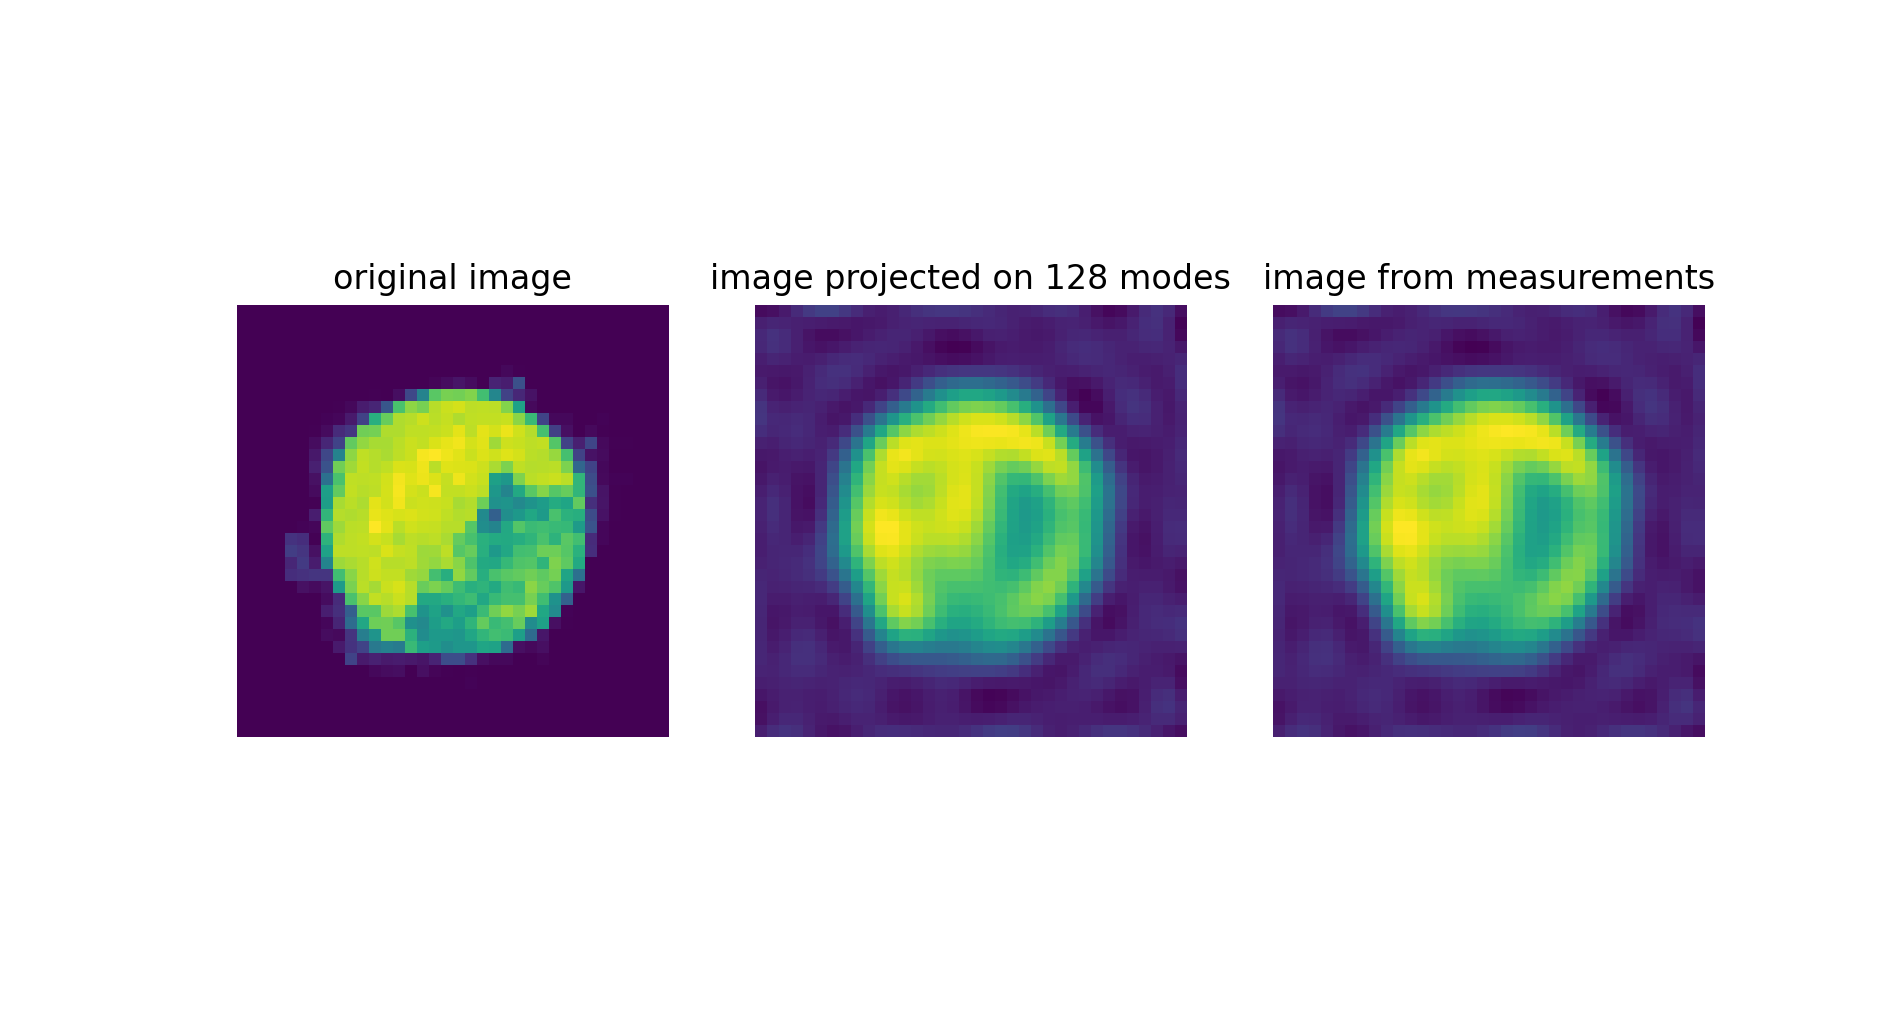

In [124]:

#measured intensities with perturbations
Is = []
for i in range(len(baselines)):
    #perturbed phase differences of each elements of the star through each pair of mirrors
    phis = (star_angles_full.dot(baselines[i]) + delays[i])*(2*np.pi/lam)
    for zeta in np.pi/2*np.arange(2):
        #measured intensities normalized by total star flux
        Is.append(a_full.dot(1 - np.cos(phis + zeta)))
Is = np.concatenate(Is)

r = 2**7#number of modes to use for estiamte the star image
# r = 2**6
# r = 150

#estimate of the star image with r modes
a_hat = U[:,-r:].dot(V[-r:].dot(Is)/s[-r:]) #note that scipy.sparse.linalg.svds arranges the singular values in increaseign order

plt.figure()
plt.subplot(131)
cmap = None
plt.imshow(im, cmap=cmap)
plt.axis("off")
plt.title("original image")
plt.subplot(132)
plt.axis("off")
plt.title("image projected on %d modes"%(r))
a_proj = U[:,-r:].dot(a_full.dot(U[:,-r:]))
plt.imshow(a_proj.reshape(im.shape), cmap=cmap)
plt.subplot(133)
plt.axis("off")
plt.title("image from measurements")
plt.imshow(a_hat.reshape(im.shape), cmap=cmap)

plt.show()